In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

<font size=6>**Introduction to Bayesian Statistics**</font>

# 1. The problem: Counting photons...

Typically, an X-ray imaging observation gives a collection of <span style="color:#d87c3a">**events**</span>: coordinates and energies of <span style="color:#d87c3a">**individual photons**</span> detected by the telescope. Essentially, we count photons, and this is why we usually refer to the photons as <span style="color:#d87c3a">**counts**</span>, while the <span style="color:#d87c3a">**count rate**</span> informs us about the number of photons per second. In general, the <span style="color:#d87c3a">*count rate scales with the flux*</span> of the field (or source) in the energy band of the telescope during the observation.

<table><tr>
<td> <img src="images/NGC1482_opt.jpg" alt="Drawing" style="height:400px;"/> </td>
<td> <img src="images/NGC1482.png" alt="Drawing" style="height: 400px;"/> </td>
</tr></table>

Using <span style="color:#d87c3a">**source detection algorithms**</span> we group photons together and generate a <span style="color:#d87c3a">list of sources and the photons we got from each</span> - namely, the *source region*. 
- For a given source, the *integrated energy of the photons from its source region* gives us an estimate on the *energy collected from the telescope*. Of course, the response of the detector and absorption effects should be accounted for. 
- Having *many counts* allows us to *fit for the spectrum* of the source. 
- Modeling the detector properties, the intergalactic absorption and the spectra allows us to <span style="color:#d87c3a">measure the *bolometric* flux</span> of the source - the flux as if we could observe the source with a perfect detector. 
- Provided we know the distance of the source we can <span style="color:#d87c3a">convert from flux to luminosity</span>... an intrinsic property of the source (which is what we usually care for)!

## 1.1. How many counts are we going to get?

<font size=3><u>**In-class discussion: If each photon count during the exposure (e.g., 50 ks) corresponds to luminosity $10^{38}\,\rm erg\,s^{-1}$, and our souce is $5\times 10^{38}\,\rm erg\,s^{-1}$, what is **on average** the number of counts we will measure?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Simply dividing we get the number of counts!
<br>

In [2]:
COUNT_TO_LUMINOSITY = 1.0e38  # in erg/s
source_luminosity = 5.0e38    # in erg/s
expected_counts = source_luminosity / COUNT_TO_LUMINOSITY
print(f"Expected counts: {expected_counts:.3f}")

Expected counts: 5.000


<font size=3><u>**In-class discussion: What is the distribution of the potential multiple count measurements?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
It's a counting problem, and we expect that it's measurement is independent (arrivals of photons, multiple experiments), so... it's Poisson!
    
$$P(\textrm{counts} | \textrm{expected}) = P(k | \lambda) = \textrm{Pois}(k; \lambda) = \dfrac{\lambda^k e^{-\lambda}}{k!} $$
<br>

> **Reminder**: *Poisson distribution* is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time if these events occur with a known constant mean rate and independently of the time since the last event.

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:**  Select the appropriate distribution and plot it.
</div>

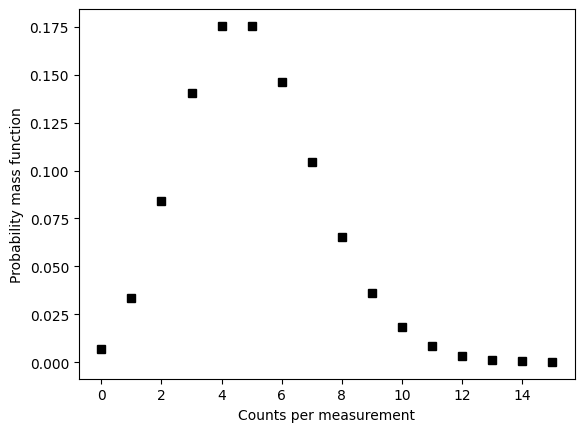

In [18]:
outcomes = np.arange(0, int(expected_counts*3)+1, 1)
pmf = st.poisson(expected_counts).pmf(outcomes)
plt.figure()
plt.plot(outcomes, pmf, "ks")
plt.xlabel("Counts per measurement")
plt.ylabel("Probability mass function")
plt.show()

<font size=3><u>**In-class discussion: What is the uncertainty on the measured counts?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Since it's Poisson, the standard deviation is the square root of the expected value!
<br>

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:**  Compute the uncertainty on the measured counts using either a formula, or a `scipy` function.
</div>

In [19]:
counts_uncertainty = expected_counts**0.5
print(f"Uncertainty: {counts_uncertainty:.3f}")

Uncertainty: 2.236


## 1.2. Estimating the luminosity of a source


<font size=3><u>**In-class discussion: Let's do the opposite now! We found a source that emitted 5 counts. What is the luminosity of the source?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
The Poisson distribution above peaks at 5 counts, but also for 4 counts. So... if we got 4 counts, 5 would also be a good answer?
There is something weird going on! We have one measurement and we ask a question about the source! Also, we are always going to get integer multiples of the count/luminosty factor this way! But nature doesn't care about the photons we got, how far away we are, etc.
<br>

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:**  Select three offsets, including zero, (can be negative or positive value) around the mean value and inspect the resulting distributions: what do you notice?
</div>

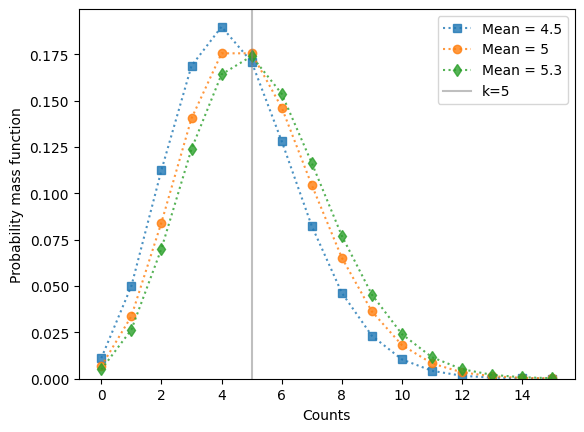

In [20]:
outcomes = np.arange(0, int(expected_counts*3)+1, 1)
plt.figure()
# try different offsets around the expected mean value and plot the PMF
for offset, marker in zip([-0.5, 0.0, 0.3], ["s", "o", "d"]):
    mean = expected_counts + offset
    plt.plot(outcomes, st.poisson(mean).pmf(outcomes), ":", marker=marker, alpha=0.8, label=f"Mean = {mean:.4g}")
plt.axvline(expected_counts, color="0.5", alpha=0.5, label="k=5")
plt.ylim(ymin=0)
plt.legend(loc="upper right")
plt.xlabel("Counts")
plt.ylabel("Probability mass function")
plt.show()

### We have multiple (actually infinite) hypotheses for the source luminosity

Before, we had the **source luminosity fixed**, and we wondered what we will measure, if repeating the experiment many times! This is the <span style="color:#d87c3a">**frequentist approach**</span>. And we also assigned uncertainty in the data!!!

> **A frequentist assigns probabilities to data - parameters are fixed. The probability is a *frequency* of data outcomes.**

But when asking about the nature of things (like in... all Science except for mathematics), then we are not interested in assigning uncertainty on the data. The data are what they are - also... they might have been fundamentally unique (some experiments cannot be repeated). We need to *assign probabilities to the quantity of interest*. This is the <span style="color:#d87c3a">**Bayesian approach**</span>:

$$ P(\textrm{hypothesis} | \textrm{data}) $$

> **A Bayesian assigns probabilities to hypotheses. The probability is a *degree of belief* in a value of a parameter.**

![image from Sivia](images/Sivia_Logic.png)

# 2. Bayes Theorem: The Foundation of Bayesian Inference

To navigate from what we can model, $P(\textrm{data} | \textrm{hypothesis})$, to what we want to know, $P(\textrm{hypothesis} | \textrm{data})$, we use **Bayes Theorem**. It arises from the basic rules of probability.

The joint probability of two events (or propositions) A and B occurring, $P(A, B)$, can be written in two ways:

$$ P(A, B) = P(A | B) P(B) $$

$$ P(A, B) = P(B | A) P(A) $$

Since $P(A,B)$ is the same in both expressions, we can equate them:

$$ P(A | B) P(B) = P(B | A) P(A) $$

Rearranging this gives us Bayes Theorem:

$$ P(A | B) = \dfrac{P(B | A) P(A)}{P(B)} $$

In the context of data and hypotheses, we write this as:

$$ P(\textrm{hypothesis} | \textrm{data}, I) = \dfrac{P(\textrm{data} | \textrm{hypothesis}, I) P(\textrm{hypothesis} | I)}{P(\textrm{data} | I)} $$

Here, $I$ represents *all our background information and assumptions*.

We made everything conditional to $I$, the **background information**: all relevant knowledge we have about the problem we are solving but are not part of the data or the specific hypothesis being tested.

For example, if we are testing whether a die is fair, the data are a sequence of outcomes (e.g., 1, 6, 3, 5, 3, 1), the hypothesis could be **the probability of rolling a 6 is $p_6$**, and $I$ = $\big\{$ all dice have 6 sides, a fair die has equiprobable sides, the laws of physics as we know them, $\cdots \big\}$.

For brevity, **we usually omit writing the $I$** in the equations, but **its always there**... somewhere in the background!

All the terms of Bayes Theorem have specific names:

*   <span style="color:#d87c3a">**Posterior Probability**</span>: $P(\text{hypothesis} | \text{data}, I)$ is the (updated) degree of belief in the hypothesis *after* considering the data.
*   <span style="color:#d87c3a">**Likelihood**</span>: $P(\text{data | hypothesis}, I)$ is the probability of observing the data *given* that the hypothesis is true. This is what we often model based on our understanding of the data generation process.
*   <span style="color:#d87c3a">**Prior Probability**</span>: $P(\text{hypothesis} | I)$ is the degree of belief in the hypothesis *before* looking at the current data. It encapsulates our previous knowledge, physical constraints, or initial assumptions.
*   <span style="color:#d87c3a">**Evidence (or Marginal Likelihood)**</span>: $P(\text{data} | I)$ is the overall probability of observing the data, averaged over all possible hypotheses. 

> In Bayesian Analysis we assign degrees of belief to hypotheses (prior), which we "update" using experimental data (via the likelihood), to arrive at a new, refined degree of belief in the hypotheses (posterior).

# 3. A Deeper Look at the Components:

## 3.1. Priors $P(\text{hypothesis} | I)$
The <span style="color:#d87c3a">prior</span> represents our state of knowledge about the hypothesis *before we consider the current dataset*. It can come from previous experiments, theoretical predictions, or fundamental principles. The choice of prior can be influential, especially with limited data, and is a key aspect of Bayesian modeling.

Priors can be broadly categorized as **informative** or **uninformative** (often, more accurately, **weakly informative**).

*   <span style="color:#d87c3a">**Informative Priors**</span>: These reflect specific, <span style="color:#d87c3a">existing information</span> about the parameter before observing the current data. This information might come from previous experiments, physical laws, or established theories. For example, if measuring the mass of a planet, an informative prior might restrict the mass to be positive and perhaps within a range plausible for planets.

*   <span style="color:#d87c3a">**Uninformative/Weakly Informative Priors**</span>: These are intended to <span style="color:#d87c3a">let the data speak for themselves</span> as much as possible, or to represent a state of relative ignorance. However, a truly "uninformative" prior is often elusive. The most common approach is to use **uniform priors**. Those assign equal probability to all possible values of a parameter within a given range. For a parameter $\theta$ bounded by $\theta_{min}$ and $\theta_{max}$, $P(\theta|I) \propto 1$. 

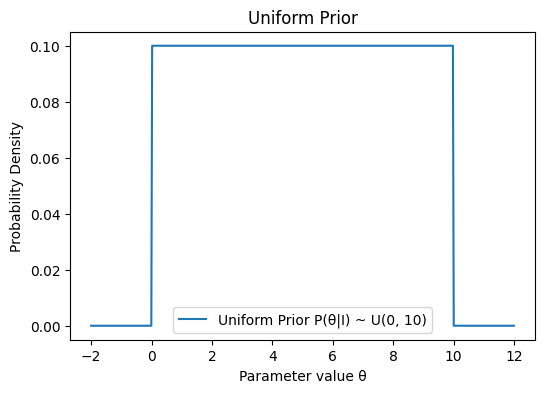

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

# Uniform Prior
x_uniform = np.linspace(-2, 12, 500)
pdf_uniform = st.uniform(loc=0, scale=10).pdf(x_uniform) # Uniform between 0 and 10
plt.plot(x_uniform, pdf_uniform, label='Uniform Prior P(θ|I) ~ U(0, 10)')
plt.title('Uniform Prior')
plt.xlabel('Parameter value θ')
plt.ylabel('Probability Density')
plt.legend()

> The choice of prior should always be justified and its impact on the results assessed, especially if strong claims are made from weakly informative data.

## 3.2. Likelihood $P(\text{data} | \text{hypothesis}, I)$
The <span style="color:#d87c3a">likelihood function</span>, $P(\text{data} | \text{hypothesis}, I)$, is the cornerstone that <span style="color:#d87c3a">connects our observed data to the parameters of our hypothesis</span>. If the data are very probable under the hypothesis, the likelihood is high. If the data are improbable, the likelihood is low. For many problems, we assume a specific mathematical form for the likelihood. Choosing an appropriate likelihood is crucial as it <span style="color:#d87c3a">encapsulates our assumptions about the data-generating process</span>. The form of the likelihood is <span style="color:#d87c3a">determined by the nature of the data and the underlying physical or statistical model</span> we believe is responsible for producing that data.

### How to Choose a Likelihood:

The choice primarily depends on:
1.  **Type of Data**: Is the data continuous (e.g., measurements of temperature, flux), discrete counts (e.g., number of photons, detected events), binary (e.g., success/failure), or categorical?
2.  **Assumed Data-Generating Process**: What statistical distribution best describes the variability or noise in the data, given a set of model parameters?

**Most Common Likelihood Functions and Their Use Cases:**

The two most commonly used likelihood functions are:

*   **Gaussian (Normal) Likelihood**:
    *   **Use Case**: For <span style="color:#d87c3a">continuous data</span> that are expected to be <span style="color:#d87c3a">symmetrically distributed</span> around a mean value, or when the <span style="color:#d87c3a">errors are assumed to be normally distributed</span> (often invoked by the Central Limit Theorem).
    *   **Example**: Measuring the brightness of a star, where instrumental noise and other random errors lead to Gaussian fluctuations around the true brightness.
    *   **Form**: If we have $N$ data points $x_i$, and our hypothesis is that they are drawn from a Gaussian with mean $\mu$ and standard deviation $\sigma$ (where $\mu$ and/or $\sigma$ could be our parameters):
        $$ P(\{x_i\} | \mu, \sigma, I) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(-\frac{(x_i-\mu)^2}{2\sigma^2}\right) $$

*   **Poisson Likelihood**:
    *   **Use Case**: For <span style="color:#d87c3a">count data</span>, representing the number of events occurring in a fixed interval of time or space, assuming events are <span style="color:#d87c3a">independent</span> and occur at a <span style="color:#d87c3a">constant average rate</span>.
    *   **Example**: Counting the number of X-ray photons ($k$) detected from a celestial source in a given observation time, where the expected mean count is $\lambda$. This is the primary example in this notebook.
    *   **Form**: If we observe $k$ counts and the expected mean is $\lambda$:
        $$ P(k | \lambda, I) = \frac{\lambda^k e^{-\lambda}}{k!} $$


**Constructing a Likelihood:**

*   **Based on Physical Models**: Often, the likelihood is derived from a physical model of the measurement process. For instance, if your instrument has a known response function, this function will inform the likelihood.
*   **Combining Distributions**: More complex likelihoods can be built by combining simpler ones, e.g., a mixture model if data can arise from different processes, or a convolution if there are multiple sources of error.
*   **Numerical Likelihoods**: If an analytical form is intractable, the likelihood might be evaluated numerically based on simulations of the data-generating process for different parameter values.

**Important Considerations:**

*   The likelihood is a function of the **parameters** of your hypothesis, for the **fixed, observed data**.
*   The choice of likelihood is a modeling choice and should be justified. If the assumptions underlying the chosen likelihood are strongly violated by the data-generating process, the Bayesian inference results may be misleading.
*   Sometimes, robust likelihoods (e.g., Student's t-distribution instead of Gaussian for data with heavy tails) are used to make inferences less sensitive to outliers.

Understanding and correctly specifying the likelihood is arguably the most critical step in a Bayesian (and frequentist) analysis, as it defines how the data inform our beliefs about the hypotheses.

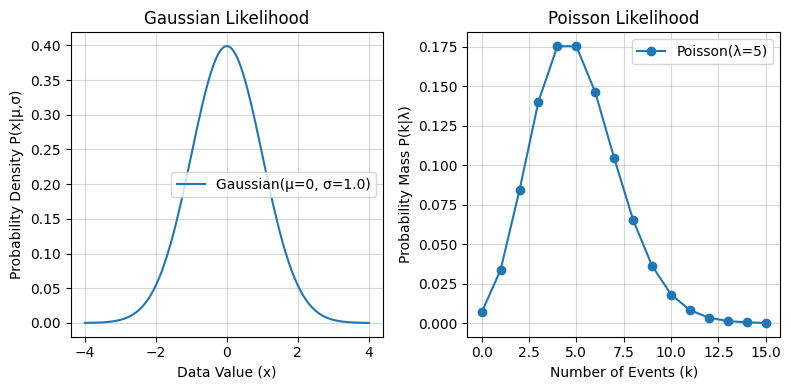

In [11]:
# Example Plots of Common Likelihood Functions
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs = axs.ravel() # Flatten the 1x2 array of axes for easy iteration

# 1. Gaussian Likelihood
mu_g, sigma_g = 0, 1.0 # Example parameters: mean, std_dev
x_g = np.linspace(mu_g - 4*sigma_g, mu_g + 4*sigma_g, 200)
pdf_g = st.norm.pdf(x_g, loc=mu_g, scale=sigma_g)
axs[0].plot(x_g, pdf_g, label=f'Gaussian(μ={mu_g}, σ={sigma_g})')
axs[0].set_title('Gaussian Likelihood')
axs[0].set_xlabel('Data Value (x)')
axs[0].set_ylabel('Probability Density P(x|μ,σ)')
axs[0].legend()
axs[0].grid(True, alpha=0.5)

# 2. Poisson Likelihood
lambda_p = 5 # Example parameter: expected rate λ
k_p = np.arange(0, lambda_p * 3 + 1)
pmf_p = st.poisson.pmf(k_p, mu=lambda_p)
axs[1].plot(k_p, pmf_p, 'o-', label=f'Poisson(λ={lambda_p})')
axs[1].set_title('Poisson Likelihood')
axs[1].set_xlabel('Number of Events (k)')
axs[1].set_ylabel('Probability Mass P(k|λ)')
axs[1].legend()
axs[1].grid(True, alpha=0.5)


plt.tight_layout()
plt.show()

## 3.3. The Evidence $P(\text{data} | I)$:
The evidence is the probability of the data, averaged over all possible values of the hypothesis parameters, weighted by their prior probabilities. If $\theta$ represents the parameters of our hypothesis, then:
$$ P(\text{data} | I) = \int P(\text{data} | \theta, I) P(\theta | I) d\theta $$
In parameter estimation problems (where we are trying to find the best values of $\theta$), the evidence $P(\text{data} | I)$ is a constant for a given dataset and model form. It ensures that the posterior probability distribution is properly normalized (i.e., integrates/sums to 1). While it often cancels out or is <span style="color:#d87c3a">ignored in parameter estimation</span> (as we often care about $P(\text{hypothesis} | \text{data}) \propto P(\text{data} | \text{hypothesis}) P(\text{hypothesis})$), the evidence is <span style="color:#d87c3a">**crucial for model comparison**</span>, a topic we will explore later. It allows us to compare how well different models (different forms of hypotheses or priors) explain the data.

## 4. Back to our counting experiment: what does Bayes say about it...

$$ P(\text{hypothesis} | \text{data}) = P(\lambda | k) \propto P(k | \lambda) P(\lambda) $$

where we ignored the evidence since its just a normalization constant for parameter estimation.

## 4.1. Assigning a prior belief on the source luminosity (and therefore its expected counts, $\lambda$)

We need to choose a prior $P(\lambda | I)$.

**Option 1: Uniform Prior over a finite range (Principle of Indifference)**
We may have a constraint - that $\lambda$ cannot be above 20 because that would make it an AGN, and we know from other measurements that its not (this is background information $I$):

$$ P(\lambda | I) = \begin{cases} C & 0\leq \lambda < 20 \\ 0 & \text{elsewhere} \end{cases}$$

The constant $C$ would be $1/20$ to normalize the prior. However, since we are interested in the shape of the posterior $P(\lambda | k) \propto P(k | \lambda) P(\lambda)$, we can often absorb normalization constants.

Then using the Poisson likelihood as in the frequentist approach:

$$ P(\lambda | k) \propto P(k | \lambda) P(\lambda) \propto \begin{cases} \dfrac{\lambda^k e^{-\lambda}}{k!}  & 0\leq \lambda < 20 \\ 0 & \text{elsewhere} \end{cases}$$

**Option 2: Uniform (Improper) Prior for $\lambda \ge 0$ (Agnostic approach)**
Maybe we have no other information and want to be **agnostic** about $\lambda$ (other than it must be non-negative, as its an expected count):

$$  P(\lambda | I) = \text{const.}, \quad \lambda \ge 0 $$

This is an **improper prior** because its integral over $[0, \infty)$ diverges. However, it can still lead to a proper posterior. Since its just a constant, it does not affect the proportionality for the posterior shape:

$$ P(\lambda | k) \propto P(k | \lambda) P(\lambda) \propto P(k | \lambda) \propto \dfrac{\lambda^k e^{-\lambda}}{k!} \quad \text{for } \lambda \ge 0$$


<font size=3><u>**In-class discussion: Are we back to frequentism using uniform priors?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
No! Bayesian inference is not just frequentism + priors. Even if the formula for the posterior $P(\lambda|k)$ looks proportional to the likelihood $P(k|\lambda)$ when using a flat prior, the interpretation is fundamentally different. 
<br><br>
The posterior $P(\lambda|k)$ is a probability distribution for the parameter $\lambda$, given the observed data $k$. The likelihood $P(k|\lambda)$ is a probability distribution for the data $k$, given a fixed parameter $\lambda$.
<br><br>
The posterior $P(\lambda | k) \propto \lambda^k e^{-\lambda}$ (for $k$ fixed, $\lambda \ge 0$) is a probability density function for the continuous quantity $\lambda$. In fact, it is a Gamma distribution: specifically, $\text{Gamma}(\text{shape}=k+1, \text{scale}=1)$ or $\text{Gamma}(\alpha=k+1, \beta=1)$ depending on parameterization (e.g., if PDF is $f(x;\alpha,\beta) = \frac{\beta^\alpha x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}$).
<br><br>
So MLE is rooted in the frequentist idea of how often data like ours would be observed if a parameter had a certain value. Bayesian inference provides a probabilistic statement about the parameter itself, given the observed data and prior beliefs.

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:**  Compute the posterior values for the trial $\lambda$ values. What is the best-fitting value for $\lambda$?
</div>

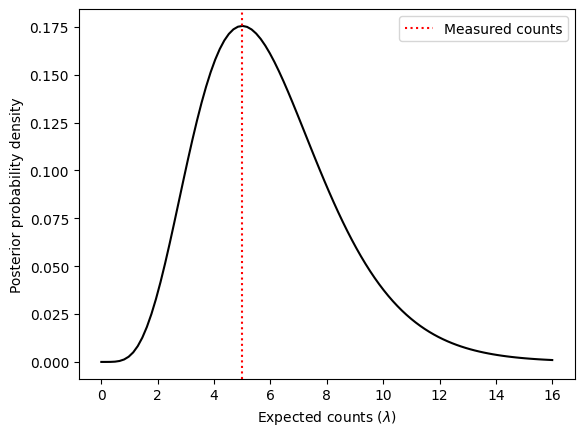

In [6]:
measure_counts = 5.0
lambda_values = np.linspace(0, int(measure_counts*3)+1, 100)
posteriors = st.poisson.pmf(measure_counts, lambda_values)

plt.figure()
plt.plot(lambda_values, posteriors, "k-")
plt.xlabel("Expected counts ($\lambda$)")
plt.ylabel("Posterior probability density")
plt.axvline(5.0, color="r", ls=":", label="Measured counts")
plt.legend(loc="upper right")
plt.show()

# 5. Parameter Marginalization: Focusing on What Matters

Often, our statistical models involve multiple parameters. However, we might only be interested in a subset of these parameters, while the others are necessary for a complete model but not of direct interest. These latter parameters are often called **nuisance parameters**.

For example, when measuring the flux ($\mu$) of a star, the noise level or background uncertainty ($\sigma$) in our measurements might also be an unknown parameter that we need to account for in our model. While we need to estimate $\sigma$ to properly assess $\mu$, our primary goal is the value of $\mu$, making $\sigma$ a nuisance parameter in this context.

Bayesian inference provides a natural and powerful way to deal with nuisance parameters through **marginalization**. If we have a joint posterior probability distribution for all parameters, say $P(\theta_1, \theta_2, ..., \theta_k | \text{data}, I)$, and we are only interested in a specific parameter (or subset of parameters) $\theta_1$, we can obtain its marginal posterior probability distribution by integrating (or summing, for discrete parameters) the joint posterior over all other nuisance parameters ($\theta_2, ..., \theta_k$):

$$ P(\theta_1 | \text{data}, I) = \int \dots \int P(\theta_1, \theta_2, \dots, \theta_k | \text{data}, I) d\theta_2 \dots d\theta_k $$

For a two-parameter case (e.g., $\mu$ and $\sigma$):
$$ P(\mu | \text{data}, I) = \int P(\mu, \sigma | \text{data}, I) d\sigma $$

The result, $P(\theta_1 | \text{data}, I)$, is the posterior probability distribution for $\theta_1$ alone, fully accounting for the uncertainty in the nuisance parameters. This means that our inferences about $\theta_1$ (like its credible interval) have properly incorporated the fact that the other parameters were not known precisely.

This is a significant advantage of the Bayesian framework. It allows us to propagate uncertainty from all parts of our model into the final inference for the quantities we care about. In frequentist statistics, dealing with nuisance parameters can sometimes be more complex, often involving techniques like profiling the likelihood or using specific test statistics designed to be insensitive to them.

<div>
<img src="images/marginalization_conditioning_example.png" width="600"/>
</div>


### 5.1. Example: Estimating Stellar Flux with Background as a Nuisance Parameter

Let’s apply marginalization in a practical setting.

Suppose we observe a noisy measurement of the total brightness from a patch of sky. This total brightness includes contributions from:

* The **flux** $F$ of a star (our parameter of interest),
* The **background** $B$ from surrounding light or instrumental effects (a nuisance parameter),
* And **Gaussian noise** with known standard deviation $\sigma$.

We model the observed value $x$ as:

$$
x \sim \mathcal{N}(F + B, \sigma^2)
$$

We will place a **broad prior** on $F$, reflecting that the star could be relatively bright or dim, and a **more informative prior** on $B$, reflecting prior knowledge about typical background levels:

$$
P(F \mid I) \sim \mathcal{N}(F; \mu_F=10.0, \sigma_F=5.0), \quad P(B \mid I) \sim \mathcal{N}(B; \mu_B=2.0, \sigma_B=1.0)
$$

Although both $F$ and $B$ are unknown, we are only interested in the posterior for $F$. To obtain it, we **marginalize out** the nuisance parameter $B$:

$$
P(F \mid x) = \int P(F, B \mid x) \, dB
$$

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:**  Define the priors, likelihood, joint posterior, and marginal posterior for $F$.
</div>

Observed value: 12.50


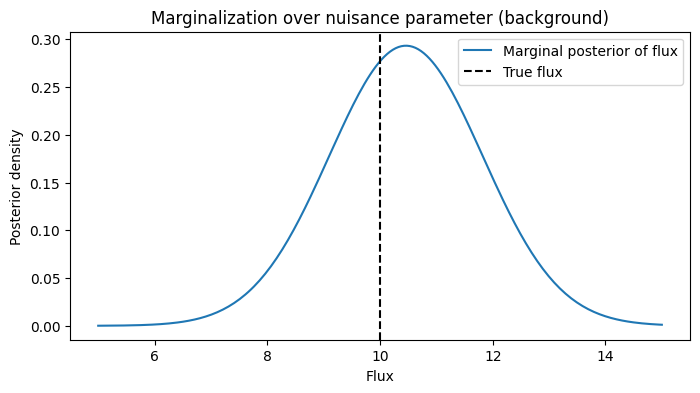

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad


# Simulated data
true_flux = 10.0
true_background = 2.0
sigma = 1.0

# One observation (flux + background + noise)
np.random.seed(42)
obs = np.random.normal(loc=true_flux + true_background, scale=sigma)

print(f"Observed value: {obs:.2f}")

# Define priors
def prior_flux(F):
    return norm.pdf(F, loc=10, scale=5)  # broad prior

def prior_background(B):
    return norm.pdf(B, loc=2, scale=1)  # informed prior

# Likelihood
def likelihood(obs, F, B):
    return norm.pdf(obs, loc=F + B, scale=sigma)

# Posterior (unnormalized, joint in F and B)
def joint_posterior(F, B):
    return likelihood(obs, F, B) * prior_flux(F) * prior_background(B)

# Marginal posterior over F (integrate out B)
def marginal_posterior_F(F):
    integrand = lambda B: joint_posterior(F, B)
    result, _ = quad(integrand, -np.inf, np.inf)
    return result

# Evaluate marginal posterior over a grid
F_vals = np.linspace(5, 15, 200)
posterior_vals = np.array([marginal_posterior_F(F) for F in F_vals])

# Normalize
posterior_vals /= np.trapz(posterior_vals, F_vals)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(F_vals, posterior_vals, label='Marginal posterior of flux')
plt.axvline(true_flux, color='k', linestyle='--', label='True flux')
plt.xlabel('Flux')
plt.ylabel('Posterior density')
plt.legend()
plt.title('Marginalization over nuisance parameter (background)')
plt.show()
